# **Quantum Computing: Lab 7**

*Note*: The jupyter notebooks for this course are _adapted_ from Peter Witteks course on <a href="https://www.edx.org/course/quantum-machine-learning-2">**Quantum Machine Learning**</a>.

Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions for the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [ ]:
%run -i "assignment_helper_QML.py"
%matplotlib inline

When we talk about quantum computing, we actually talk about several different paradigms. The most common one is gate-model quantum computing, in the vein we discussed in the previous notebook. In this case, gates are applied on qubit registers to perform arbitrary transformations of quantum states made up of qubits.

The second most common paradigm is quantum annealing. This paradigm is often also referred to as adiabatic quantum computing, although there are subtle differences. Quantum annealing solves a more specific problem -- universality is not a requirement -- which makes it an easier, albeit still difficult engineering challenge to scale it up. The technology is up to 2000 superconducting qubits in 2018, compared to the less than 100 qubits on gate-model quantum computers. D-Wave Systems has been building superconducting quantum annealers for over a decade and this company holds the record for the number of qubits -- 2048. More recently, an IARPA project was launched to build novel superconducting quantum annealers. A quantum optics implementation was also made available by QNNcloud that implements a coherent Ising model. Its restrictions are different from superconducting architectures.

Gate-model quantum computing is conceptually easier to understand: it is the generalization of digital computing. Instead of deterministic logical operations of bit strings, we have deterministic transformations of (quantum) probability distributions over bit strings. Quantum annealing requires some understanding of physics, which is why we introduced classical and quantum many-body physics in a previous notebook. Over the last few years, quantum annealing inspired gate-model algorithms that work on current and near-term quantum computers (see the notebook on variational circuits). So in this sense, it is worth developing an understanding of the underlying physics model and how quantum annealing works, even if you are only interested in gate-model quantum computing.

While there is a plethora of quantum computing languages, frameworks, and libraries for the gate-model, quantum annealing is less well-established. D-Wave Systems offers an open source suite called Ocean. A vendor-independent solution is XACC, an extensible compilation framework for hybrid quantum-classical computing architectures, but the only quantum annealer it maps to is that of D-Wave Systems. Since XACC is a much larger initiative that extends beyond annealing, we choose a few much simpler packages from Ocean to illustrate the core concepts of this paradigm. However, before diving into the details of quantum annealing, it is worth taking a slight detour to connect the unitary evolution we discussed in a closed system and in the gate-model paradigm and the Hamiltonian describing a quantum many-body system. We also briefly discuss the adiabatic theorem, which provides the foundation why quantum annealing would work at all.

# Unitary evolution and the Hamiltonian

We introduced the Hamiltonian as an object describing the energy of a classical or quantum system. Something more is true: it gives a description of a system evolving with time. This formalism is expressed by the Schrödinger equation:

$$
i\hbar {\frac {d}{dt}}|\psi(t)\rangle = H|\psi(t)\rangle,
$$

where $\hbar$ is the reduced Planck constant. Previously we said that it is a unitary operator that evolves state. That is exactly what we get if we solve the Schrödinger equation for some time $t$: $U = \exp(-i Ht/\hbar)$. Note that we used that the Hamiltonian does not depend on time. In other words, every unitary we talked about so far has some underlying Hamiltonian.

The Schrödinger equation in the above form is the time-dependent variant: the state depends on time. The time-independent Schrödinger equation reflects what we said about the Hamiltonian describing the energy of the system:

 $$
 H|\psi \rangle =E|\psi \rangle,
$$

where $E$ is the total energy of the system.

# The adiabatic theorem and adiabatic quantum computing

An adiabatic process means that conditions change slowly enough for the system to adapt to the new configuration. For instance, in a quantum mechanical system, we can start from some Hamiltonian $H_0$ and slowly change it to some other Hamiltonian $H_1$. The simplest change could be a linear schedule:

$$
H(t) = (1-t) H_0 + t H_1,
$$

for $t\in[0,1]$ on some time scale. This Hamiltonian depends on time, so solving the Schrödinger equation is considerably more complicated. The adiabatic theorem says that if the change in the time-dependent Hamiltonian occurs slowly, the resulting dynamics remain simple: starting close to an eigenstate, the system remains close to
an eigenstate. This implies that if the system started in the ground state, if certain conditions are met, the system stays in the ground state. 

We call the energy difference between the ground state and the first excited state the gap. If $H(t)$ has a nonnegative gap for each $t$ during the transition and the change happens slowly, then the system stays in the ground state. If we denote the time-dependent gap by $\Delta(t)$, a course approximation of the speed limit scales as $1/\min(\Delta(t))^2$.

This theorem allows something highly unusual. We can reach the ground state of an easy-to-solve quantum many body system, and change the Hamiltonian to a system we are interested in. For instance, we could start with the Hamiltonian $\sum_i \sigma^X_i$ -- its ground state is just the equal superposition. Let's see this on two sites:

In [ ]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)

X = np.array([[0, 1], [1, 0]])
IX = np.kron(np.eye(2), X)
XI = np.kron(X, np.eye(2))
H_0 = -(IX + XI)
λ, v = np.linalg.eigh(H_0)
print(v)
print("Eigenvalues:", λ)
print("Eigenstate for lowest eigenvalue", v[:, 0])

Then we could turn this Hamiltonian slowly into a classical Ising model and read out the global solution.

<img src="images/annealing_process.svg" alt="Annealing process" style="width: 700px;"/>


Adiabatic quantum computation exploits this phenomenon and it is able to perform universal calculations with the final Hamiltonian being $H=-\sum_{<i,j>} J_{ij} \sigma^Z_i \sigma^Z_{j} - \sum_i h_i \sigma^Z_i - \sum_{<i,j>} g_{ij} \sigma^X_i\sigma^X_j$. Note that is not the transverse-field Ising model: the last term is an X-X interaction. If a quantum computer respects the speed limit, guarantees the finite gap, and implements this Hamiltonian, then it is equivalent to the gate model with some overhead.

The quadratic scaling on the gap does not appear too bad. So can we solve NP-hard problems faster with this paradigm? It is unlikely. The gap is highly dependent on the problem, and actually difficult problems tend to have an exponentially small gap. So our speed limit would be quadratic over the exponentially small gap, so the overall time required would be exponentially large.

# Quantum annealing

A theoretical obstacle to adiabatic quantum computing is that calculating the speed limit is clearly not trivial; in fact, it is harder than solving the original problem of finding the ground state of some Hamiltonian of interest. Engineering constraints also apply: the qubits decohere, the environment has finite temperature, and so on. *Quantum annealing* drops the strict requirements and instead of respecting speed limits, it repeats the transition (the annealing) over and over again. Having collected a number of samples, we pick the spin configuration with the lowest energy as our solution. There is no guarantee that this is the ground state.

Quantum annealing has a slightly different software stack than gate-model quantum computers. Instead of a quantum circuit, the level of abstraction is the classical Ising model -- the problem we are interested in solving must be in this form. Then, just like superconducting gate-model quantum computers, superconducting quantum annealers also suffer from limited connectivity. In this case, it means that if our problem's connectivity does not match that of the hardware, we have to find a graph minor embedding. This will combine several physical qubits into a logical qubit. The workflow is summarized in the following diagram [[1](#1)]:

<img src="images/quantum_annealing_workflow.png" alt="Software stack on a quantum annealer" style="width: 700px;"/>

A possible classical solver for the Ising model is the simulated annealer: $ x_1x_2 - x_2x_3$

In [4]:
import dimod

J = {(1, 2): 1.0, (2, 3): -1.0}
h = {1:0, 2:0, 3:0}

J = {(1,2): -1, (1,4): 1, (2,3): 10}
h = {3: -1, 4: -10}

#x2.x3 = x4

#$\max f(x) = -x_3 -10 x_4 -x_1x_2 +x_1x_4 + 10x_2x_3)$.

model = dimod.BinaryQuadraticModel(h, J, 0, dimod.BINARY)


sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=100)
for solution in response.data():
    print(solution.sample.values(), solution.energy)


dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_values([0, 0, 1, 1]) -11.0
dict_val

Let's take a look at the minor embedding problem. This part is NP-hard in itself, so we normally use  probabilistic heuristics to find an embedding. For instance, for many generations of the quantum annealer that D-Wave Systems produces has unit cells containing a $K_{4,4}$ bipartite fully-connected graph, with two remote connections from each qubit going to qubits in neighbouring unit cells. A unit cell with its local and remote connections indicated is depicted following figure:

<img src="images/unit_cell.png" alt="Unit cell in Chimera graph" style="width: 80px;"/>

This is called the Chimera graph. The current largest hardware has 2048 qubits, consisting of $16\times 16$ unit cells of 8 qubits each. The Chimera graph is available as a `networkx` graph in the package `dwave_networkx`. We draw a smaller version, consisting of $2\times 2$ unit cells.

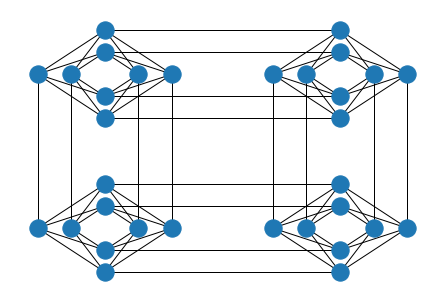

In [5]:
import matplotlib.pyplot as plt
import dwave_networkx as dnx
%matplotlib inline

connectivity_structure = dnx.chimera_graph(2, 2)
dnx.draw_chimera(connectivity_structure)
plt.show()

Let's create a graph that certainly does not fit this connectivity structure. For instance, the complete graph $K_n$ on nine nodes:

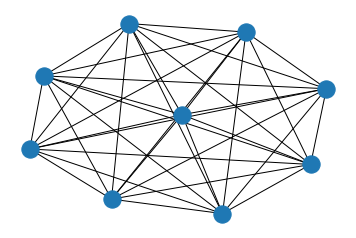

In [6]:
import networkx as nx
G = nx.complete_graph(9)
plt.axis('off') 
nx.draw_networkx(G, with_labels=False)

In [7]:
import minorminer
embedded_graph = minorminer.find_embedding(G.edges(), connectivity_structure.edges())

Let's plot this embedding:

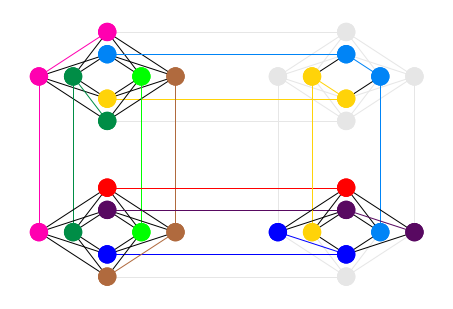

In [8]:
dnx.draw_chimera_embedding(connectivity_structure, embedded_graph)
plt.show()

# References

[1] M. Fingerhuth, T. Babej, P. Wittek. (2018). [Open source software in quantum computing](https://doi.org/10.1371/journal.pone.0208561). *PLOS ONE* 13(12):e0208561.  <a id='1'></a>

# **EXERCISES**: Unitary evolution and the Hamiltonian

**Exercise 1** (2 points). You have already seen that the eigendecomposition of a Hamiltonian gives you the energy levels of the system. This comes out of the time-independent Schrödinger equation, $H|\psi \rangle =E|\psi \rangle$.

The solution of the time-dependent Schrödinger equation establishes the connection between unitary operations (solutions of the Schrödinger equation) and the Hamiltonian. Imagine, for instance, that you are looking for the Hamiltonian that implements the phase gate $S=\begin{bmatrix}1 & 0\\ 0& i\end{bmatrix}$. This is a valid unitary, so we are looking for a time-independent Hamiltonian such that $S = \exp(-i Ht/\hbar)$. The $S$ gate is diagonal, so will be our Hamiltonian. That makes matrix exponentiation easy. So we are looking for a Hamiltonian $H=\begin{bmatrix}h_1 & 0\\0 & h_2\end{bmatrix}$ for some values $h_1$ and $h_2$.

We can take, for instance $\sigma^Z=\begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}$ and substract an identity matrix -- this only shifts the energy. That would give us a Hamiltonian $H=\sigma^Z-\mathbb{1}=\begin{bmatrix}0 & 0\\0 & -2\end{bmatrix}$. So now we have $S=\exp(-i Ht/\hbar)=\begin{bmatrix}\exp(-i 0t/\hbar) & 0\\0 & \exp(i 2t/\hbar)\end{bmatrix}=\begin{bmatrix}1 & 0\\0 & \exp(i 2t/\hbar)\end{bmatrix}$. Calculate the value for $t/\hbar$ to get the $S$ gate from this Hamiltonian. Store the result in a variable called `t`.

In [2]:
import numpy as np

t = np.arcsin(1)/2
print(t)



0.7853981633974483


This tells you for how long you would have to evolve the Hamiltonian to get the effect of an $S$ gate.

# The adiabatic theorem

**Exercise 2** (2 points). In an adiabatic process, conditions change slowly enough for the system to adapt to the new configuration. We can start from some Hamiltonian $H_0$ and slowly change it to some other Hamiltonian $H_1$, for instance, on a linear schedule: $H(t) = (1-t) H_0 + t H_1$. The speed of change heavily depends on the energy gap, that is, the difference between the ground state energy and the first excited state of all Hamiltonians $H(t)$, $t\in[0,1]$.

It is easy to craft a Hamiltonian where this gap is small, so the speed limit has to be low. If you take a classical Ising model with coupling strengths on vastly different scales, that is what you get. For instance, calculate the gap (the difference between the smallest and second smallest eigenvalue) of the Hamitonian $H_1=-1000\sigma^Z_1\sigma^Z_2-0.1\sigma^Z_2\sigma^Z_3-0.5\sigma^Z_1$ acting on a three-qubit system (the last linear term is there to make the ground state unique). The result should be in a variable called `gap`. Remember that since you have three qubits, the $\sigma^Z_1\sigma^Z_2$ operator, for instance, actually means $\sigma^Z\otimes\sigma^Z\otimes\mathbb{1}$.

In [11]:
import numpy as np
from numpy import linalg as LA
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

h0 = -1000*np.kron(np.kron(Z,Z), I)
h1 = -0.1*np.kron(np.kron(I,Z), Z)
h2 = -0.5*np.kron(np.kron(Z,I), I)
H = h0+h1+h2

eigVals, eigVecs = LA.eig(H)

gap = eigVals[0] - eigVals[1]

print(gap)


[-1000.6 -1000.4   999.6   999.4  1000.4  1000.6  -999.4  -999.6]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


**Exercise 3** (1 point). Contrast this to the gap of the Hamiltonian $H_0 = \sum_{i=1}^3 -\sigma^X_i$. Again, calculate the value in a variable called `gap`.

In [3]:
import numpy as np
from numpy import linalg as LA
X = np.array([[0, 1], [1, 0]])
I = np.array([[1, 0], [0, 1]])

h0 = -np.kron(np.kron(X,I), I)
h1 = -np.kron(np.kron(I,X), I)
h2 = -np.kron(np.kron(I,I), X)
H = h0+h1+h2

eigVals, eigVecs = LA.eig(H)

gap = eigVals[0] - eigVals[1]

print(eigVals)
print(gap)


[ 3. -3. -1. -1.  1.  1. -1.  1.]
[[ 3.53553391e-01 -3.53553391e-01 -6.12372436e-01 -2.04990925e-02
  -3.58224779e-16 -6.12372436e-01  2.06182428e-03  5.48207252e-02]
 [-3.53553391e-01 -3.53553391e-01 -2.04124145e-01  4.01186461e-01
   4.08248290e-01  2.04124145e-01 -5.76438549e-01 -3.41413036e-01]
 [-3.53553391e-01 -3.53553391e-01 -2.04124145e-01 -5.64198021e-01
  -5.57677536e-01  2.04124145e-01  3.03088681e-01 -2.68628747e-01]
 [ 3.53553391e-01 -3.53553391e-01  2.04124145e-01 -1.42512468e-01
   1.49429245e-01  2.04124145e-01 -2.75411692e-01  5.55221058e-01]
 [-3.53553391e-01 -3.53553391e-01 -2.04124145e-01  1.42512468e-01
   1.49429245e-01  2.04124145e-01  2.75411692e-01  5.55221058e-01]
 [ 3.53553391e-01 -3.53553391e-01  2.04124145e-01  5.64198021e-01
  -5.57677536e-01  2.04124145e-01 -3.03088681e-01 -2.68628747e-01]
 [ 3.53553391e-01 -3.53553391e-01  2.04124145e-01 -4.01186461e-01
   4.08248290e-01  2.04124145e-01  5.76438549e-01 -3.41413036e-01]
 [-3.53553391e-01 -3.53553391e-01  

You can see that there is a vast difference in the gap between the two Hamiltonians. This could be leveraged: for instance, the initial part of the annealing could go faster, since the gap is large, and then slow down towards reaching the target Hamiltonian. The optimal annealing schedule is a research topic on its own.

# Quantum annealing

**Exercise 4** (1 point). On a real quantum annealing device, we drop the stringent theoretical requirements of following the adiabatic pathway and we repeat the transition over and over again. Then we choose the lowest energy solution as our optimum.

The classical 'simulator' for a quantum annealer is some heuristic solver of combinatorial optimization, for instance, simulated annealing. Use the dimod package to implement the Hamiltonian with a small gap: $H_1=-1000\sigma^Z_1\sigma^Z_2-0.1\sigma^Z_2\sigma^Z_3-0.5\sigma^Z_1$. Your solution should be a `BinaryQuadraticModel` in an object called `model`. 

Example `model = dimod.BinaryQuadraticModel(linear_terms, quadratic_terms, offset_energy, dimod.SPIN)`

In [12]:
import dimod


quadratic_terms = {(1, 2): -1000.0, (2, 3): -0.1}
linear_terms = {1:-0.5}

model = dimod.BinaryQuadraticModel(
    linear_terms, quadratic_terms, 0, dimod.SPIN)


In [13]:
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=10)
assert np.isclose(response.first.energy, -1000.6)

Unlike in the case of a simple system, you often do not get the ground state:

In [14]:
print([solution.energy for solution in response.data()])

[-1000.6, -1000.6, -1000.6, -1000.6, -1000.6, -1000.6, -999.6, -999.6, -999.6, -999.6]


This shows that the problem is also hard for a classical heuristic solver, which should not come as a surprise.

# Solving Integer Programmming with Quantum Annealing

**Exercise**: Given, 



$\begin{align}
\max & (x_1 + x_2 + x_3 + x_4) \\
s.t. & \\
& x_1 +x_3+x_4 \leq 1\\
& x_1 +x_2 \leq 5 \\
& x_i \in \{0,1\}, \forall i
\end{align}$

In [25]:
import dimod

quadratic = {(1,2): 0.4, (1,4): 10, (1,3): 10, (3,4): 10}
linear = {1:-1, 2:-1, 3:-1, 4:-1 }
model = dimod.BinaryQuadraticModel(linear, quadratic, 0, dimod.BINARY)


sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=5)
for solution in response.data():
    print(solution.sample.values(), solution.energy)


dict_values([0, 1, 0, 1]) -2.0
dict_values([0, 1, 0, 1]) -2.0
dict_values([0, 1, 1, 0]) -2.0
dict_values([0, 1, 1, 0]) -2.0
dict_values([0, 1, 0, 1]) -2.0


In [26]:
import dimod


Q = {(1,1): -1, (1,2): 0.4/2, (1,4): 5, (1,3): 5, (3,4): 5,
     (2,2): -1, 
     (3,3): -1,
     (4,4): -1}

solver = dimod.ExactSolver()
response = solver.sample_qubo(Q)


for datum in response.data(['sample', 'energy']):
    print(datum.sample.values(), datum.energy)


dict_values([0, 1, 1, 0]) -2.0
dict_values([0, 1, 0, 1]) -2.0
dict_values([1, 1, 0, 0]) -1.8
dict_values([1, 0, 0, 0]) -1.0
dict_values([0, 1, 0, 0]) -1.0
dict_values([0, 0, 1, 0]) -1.0
dict_values([0, 0, 0, 1]) -1.0
dict_values([0, 0, 0, 0]) 0.0
dict_values([0, 1, 1, 1]) 2.0
dict_values([1, 1, 1, 0]) 2.2
dict_values([1, 1, 0, 1]) 2.2
dict_values([1, 0, 1, 0]) 3.0
dict_values([0, 0, 1, 1]) 3.0
dict_values([1, 0, 0, 1]) 3.0
dict_values([1, 1, 1, 1]) 11.2
dict_values([1, 0, 1, 1]) 12.0


# Solving MAX 3-SAT with Quantum Annealing

Given a SAT formula $\phi = (x_1 \vee x_2 \vee x_3) \wedge (\overline{x_1} \vee x_2 \vee x_3) \wedge (x_1 \vee \overline{x_2} \vee x_3)$, such that any $x_i \in \{0,1\}$. Find all $x_i$'s such that $\phi = 1$ (TRUE).

NOTE: $\vee = $ **OR** and $\wedge = $ **AND**

**Converting Boolean formula to polynomial**

* $x \vee y = x+y-xy$
* $\overline{x} = 1-x$

**Task**: Convert $\phi$ above to a polynomial.

1. **First Clause**: $(x_1 \vee x_2 \vee x_3)$


$\begin{align}
x_1 \vee x_2 \vee x_3   &= (x_1 \vee x_2) \vee x_3 \\
&= (x_1+x_2-x_1x_2)\vee x_3 \\
&= (x_1+x_2-x_1x_2)+ x_3 - (x_1+x_2-x_1x_2) x_3 \\
\phi_1&= x_1+x_2+x_3-x_1x_2-x_2x_3-x_1x_3+x_1x_2x_3 
\end{align}$

2. **Second Clause**: $(\overline{x_1} \vee x_2 \vee x_3)$

$\begin{align}
\overline{x_1} \vee x_2 \vee x_3   &= (\overline{x_1} \vee x_2) \vee x_3 \\
&= (\overline{x_1}+x_2-\overline{x_1}x_2)\vee x_3 \\
&= (\overline{x_1}+x_2-\overline{x_1}x_2)+ x_3 - (\overline{x_1}+x_2-\overline{x_1}x_2) x_3 \\
&= \overline{x_1}+x_2+x_3-\overline{x_1}x_2-x_2x_3-\overline{x_1}x_3+\overline{x_1}x_2x_3 \\
&= (1-x_1)+x_2+x_3-(1-x_1)x_2-x_2x_3-(1-x_1)x_3+(1-x_1)x_2x_3 \\
&= 1-x_1+x_2+x_3-x_2+x_1x_2-x_2x_3-x_3+x_1x_3+x_2x_3-x_1x_2x_3 \\
\phi_2&= 1-x_1+x_1x_2+x_1x_3-x_1x_2x_3 
\end{align}$
            
3. **Third Clause**: $(x_1 \vee \overline{x_2} \vee x_3)$

$\begin{align}
x_1 \vee \overline{x_2} \vee x_3   &= (x_1 \vee \overline{x_2}) \vee x_3 \\
&= (x_1+\overline{x_2}-x_1\overline{x_2})\vee x_3 \\
&= (x_1+\overline{x_2}-x_1\overline{x_2})+ x_3 - (x_1+\overline{x_2}-x_1\overline{x_2}) x_3 \\
&= x_1+\overline{x_2}+x_3-x_1\overline{x_2}-\overline{x_2}x_3-x_1x_3+x_1\overline{x_2}x_3 \\
&= x_1+(1-x_2)+x_3-x_1(1-x_2)-(1-x_2)x_3-x_1x_3+x_1(1-x_2)x_3 \\
&= x_1+1-x_2+x_3-x_1+x_1x_2-x_3+x_2x_3-x_1x_3+x_1x_3-x_1x_2x_3 \\
\phi_3&= 1-x_2+x_1x_2+x_2x_3-x_1x_2x_3
\end{align}$            

Thus, our SAT formula $\phi$ is


$\begin{align}
\phi &= \phi_1 \wedge \phi_2 \wedge \phi_3\\
&= \phi_1  \phi_2  \phi_3  \\
&= \max \sum\limits_{i=1}^{3} \phi_i
\end{align}$

$\begin{align}
\phi = \max [ x_1+x_2+x_3-x_1x_2-x_2x_3-x_1x_3+x_1x_2x_3+1-x_1+x_1x_2+x_1x_3-x_1x_2x_3+1-x_2+x_1x_2+x_2x_3-x_1x_2x_3]
\end{align}$

$\begin{align}
\phi = \max [2+x_3+x_1x_2 -x_1x_2x_3]
\end{align}$

Hence, we have our optimization problem is,

$\max f(x) = 2+x_3+x_1x_2 -x_1x_2x_3$

**Exercise**: Is $f(x)$ a QUBO?


Let $x_2x_3 = x_4$ and add penalty $P(x_2x_3 - 2x_2x_4 - 2x_3x_4 + 3x_4)$.

Thus our problem is now $\max f(x) = 2+x_3+x_1x_2 -x_1x_4 - P(x_2x_3 - 2x_2x_4 - 2x_3x_4 + 3x_4)$.

$\max f(x) = 2+x_3 - 30x_4 +x_1x_2 -x_1x_4-10x_2x_3 +20 x_2x_4 + 20x_3x_4$

$\max f(x) = x_3 - 30x_4 +x_1x_2 -x_1x_4-10x_2x_3 +20 x_2x_4 + 20x_3x_4$

$\min f(x) = -x_3 +30x_4 -x_1x_2 +x_1x_4 +10x_2x_3 -20 x_2x_4 - 20x_3x_4$

$\min f(x) = -x_3^2 +30x_4^2 -x_1x_2 +x_1x_4 +10x_2x_3 -20 x_2x_4 - 20x_3x_4$

**The reason for this penalty: $x_2x_3 - 2x_2x_4 - 2x_3x_4 + 3x_4=0$ _iff_ $x_2x_3 =x_4$.**

**Exercise**: Let $P = 10$, fomulate the QUBO matrix.

In [ ]:
import dimod

quadratic = {(1,2): -1, (1,4): 1, (2,3): 10, (2,4): -20, (3,4): -20}
linear = {1: 0, 2: 0, 3: -1, 4: 30}


model = dimod.BinaryQuadraticModel(linear, quadratic, 0, dimod.BINARY)
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample(model, num_reads=5)
for solution in response.data():
    print(solution.sample.values(), solution.energy)


In [ ]:
import dimod

Q = {('1','1'): 0, ('1','2'): -1, ('1','3'): 0, ('1','4'): 1,
     ('2','2'): 0, ('2','3'): 10, ('2','4'): -20,
     ('3','3'): -1, ('3','4'): -20,
     ('4','4'): 30}

solver = dimod.ExactSolver()
response = solver.sample_qubo(Q)


for datum in response.data(['sample', 'energy']):
    print(datum.sample.values(), datum.energy)